<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/FlexibleReminRatios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cvxpy as cp

In [2]:
!pip install gsw

     |████████████████████████████████| 2.4MB 13.2MB/s 


In [3]:
import gsw

In [4]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ' -O names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv

--2021-01-11 18:19:10--  https://docs.google.com/uc?export=download&id=1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ
Resolving docs.google.com (docs.google.com)... 108.177.126.113, 108.177.126.102, 108.177.126.101, ...
Connecting to docs.google.com (docs.google.com)|108.177.126.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ko1jposp2ts7pgu9615e081quumd4fm7/1610389125000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download [following]
--2021-01-11 18:19:11--  https://doc-0s-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ko1jposp2ts7pgu9615e081quumd4fm7/1610389125000/06203730782251856755/*/1Gla6o_YihOCfU5pWGLhFvL-TKm_0aXfQ?e=download
Resolving doc-0s-a4-docs.googleusercontent.com (doc-0s-a4-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-0s-a4-docs.googleusercontent.com (doc-0s-

In [70]:
!pip uninstall -y pyompa
%cd /content/
!rm -rf pyompa
!git clone https://github.com/nitrogenlab/pyompa
%cd /content/pyompa
!pip install .
%cd /content/

%reload_ext autoreload
%autoreload 2
from importlib import reload
import pyompa
reload(pyompa)

Uninstalling pyompa-1.0.0.0:
  Successfully uninstalled pyompa-1.0.0.0
/content
Cloning into 'pyompa'...
remote: Enumerating objects: 134, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 134 (delta 88), reused 85 (delta 44), pack-reused 0
Receiving objects: 100% (134/134), 27.30 KiB | 1.52 MiB/s, done.
Resolving deltas: 100% (88/88), done.
/content/pyompa
Processing /content/pyompa
  Created wheel for pyompa: filename=pyompa-1.0.0.0-cp36-none-any.whl size=12547 sha256=2485426ac75bfbb63d5ca30c3e7d9a17a3ebff83ce3ab0e57b6b58a1e4b50b97
  Stored in directory: /tmp/pip-ephem-wheel-cache-n2q69nzu/wheels/c8/e7/18/86bb9113ba57075c1244f892ac172edfebb6b9de263279873f
Successfully built pyompa


/content


<module 'pyompa' from '/usr/local/lib/python3.6/dist-packages/pyompa/__init__.py'>

In [9]:
import pandas as pd
import numpy as np

def augment_df_with_PO_NO_SiO(df):  
  #remineralization ratios
  r_PO = 155;
  r_SiO = 15
  r_NO = 9.68
  df["PO"] = df["oxygen"] + df["phosphate"]*r_PO
  df["NO"] = df["oxygen"] + df["nitrate"]*r_NO
  df["SiO"] = df["oxygen"] + df["silicate"]*r_SiO

header = ["c"+str(i) for i in range(1,30)]
header[4] = "bottle flag"
header[16] = "bottle salinity flag"
header[20] = "bottle oxygen flag"
header[22] = "silicate flag"
header[24] = "nitrate flag"
header[28] = "phosphate flag"

header[11] = "CTD pressure"
header[12] = "CTD temperature"
header[15] = "practical_salinity" #practical salinity
header[8] = "latitude"
header[9] = "longitude"

header[0] = "stnnbr"
header[5] = "geotrc_ID"
header[10] = "bottom depth"
header[19] = "oxygen"
header[21] = "silicate"
header[23] = "nitrate"
header[27] = "phosphate"

gp15_df = pd.read_csv("names_added_GP15OMPA_33RR20180918_only_gs_rosette_clean1_hy1.csv",
                      names=header, na_values = -999)

#remove bad data
for flag_type in ["bottle flag", "bottle salinity flag", "bottle oxygen flag",
                  "silicate flag", "nitrate flag", "phosphate flag"]:
    gp15_df = gp15_df[gp15_df[flag_type] <= 2]
gp15_df = pd.DataFrame(gp15_df)

#create PO offset
#gp15_df["phosphate"] = gp15_df["phosphate"] - 0.2

#add PO and NO to data frame
augment_df_with_PO_NO_SiO(gp15_df)

absolute_salinity = gsw.SA_from_SP(SP=gp15_df["practical_salinity"],
                                   p=gp15_df["CTD pressure"],
                                   lon=gp15_df["longitude"],
                                   lat=gp15_df["latitude"])
gp15_df["absolute_salinity"] = absolute_salinity

conservative_temp = gsw.CT_from_t(SA=absolute_salinity,
                                  t=gp15_df["CTD temperature"],
                                  p=gp15_df["CTD pressure"])
gp15_df["conservative_temp"] = conservative_temp

potential_temp = gsw.pt_from_CT(SA=absolute_salinity,
                                CT=conservative_temp)
gp15_df["potential_temp"] = potential_temp

sig0 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=0) - 1000
gp15_df["sig0"] = sig0
sig1500 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=1500) - 1000
sig2000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=2000) - 1000
sig3000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=3000) - 1000
sig4000 = gsw.rho(SA=absolute_salinity, CT=conservative_temp, p=4000) - 1000

z = gsw.z_from_p(p=gp15_df["CTD pressure"], lat=gp15_df["latitude"])
depth = -z #https://github.com/TEOS-10/python-gsw/blob/7d6ebe8114c5d8b4a64268d36100a70e226afaf6/gsw/gibbs/conversions.py#L577
gp15_df["depth"] = depth

spic0 = gsw.spiciness0(SA=absolute_salinity, CT=conservative_temp)
gp15_df["spiciness"] = spic0

#calculation of planetary vorticity
rho_ref = 1000.0 #reference density
Omega = 2*np.pi/86400;
f = np.mean(2*Omega*np.sin(gp15_df["latitude"]*(np.pi/180.0)))
PV = -(f/rho_ref)*(np.gradient(sig0, depth))
gp15_df["PV"] = PV #potential vorticity

print("Rows:",len(gp15_df))
gp15_df = gp15_df.dropna()
print("Rows without NA values:",len(gp15_df))

gp15_df["mass"] = 1

Rows: 940
Rows without NA values: 926


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1072: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1073: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1074: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:1080: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


In [10]:
def prepare_water_mass_df(water_mass_arr):
    df = pd.DataFrame(data=water_mass_arr,
                      columns=["watermassname",
                               "potential_temp", "practical_salinity",
                               "oxygen", "phosphate", "silicate",
                               "nitrate", "spiciness", "PV"])
    augment_df_with_PO_NO_SiO(df)
    df["mass"] = 1
    return df

                             #Temp  Sal     Oxy     Phos   Sili   Nitr    Spic      Vort
P16_Emilie_AAIW = ["AAIW",    5.68, 34.307, 237.0,  1.77,  16.60, 25.5,   0.068,    88.86E-12]
PSUW =            ["PSUW",    4.03, 33.38,	174.7,	2.35,  59.34, 31.24,  -0.964,  970.78E-12]
GLODAP_ESSW =     ["ESSW",   12.2,  34.86,  84.6,   1.87,  21.58, 25.87,   1.419,    2.66E-12]
GLODAP_mystery =  ["Mystery", 2.09, 34.53,   36.1,  3.03, 168.87, 43.5,  -0.154,    26.95E-12]
GLODAP_EqPIW =    ["EqPIW",   7.65, 34.60,   48.50, 2.71,  44.53, 38.26,  0.568,     0.01E-12]
GLODAP_NPIW =     ["NPIW",    4.72, 34,      81.8,  2.64,  79.87, 36.48, -0.262,   130.26E-12]
PDW1 =            ["PDW1",    1.78, 34.59,   59.60, 2.92, 166.62, 41.38, -0.140,    19.14E-12]
P16_UCDW =        ["UCDW",    2.6,  34.575, 168,    2.4,   85.7,  34.4,  -0.1,      37.49E-12]
PDW23 =           ["PDW23",   1.23, 34.67,  128.50, 2.62, 164.89, 37.24, -0.182,     6.05E-12]
P16_LCDW =        ["LCDW",    1.62, 34.738, 195,    2.17,  96.6,  31,    -0.066,    12.55E-12]
GLODAP_AABW =     ["AABW",    0.18, 34.70,  219,    2.27, 124.45, 32.57, -0.203,     2.90E-12]


intermediateanddeep_withpenalty_flexibleconversion rian_weighting_withconversion
[('nitrate', 50), ('phosphate', 50), ('oxygen', 10)]
Adding penalty for PSUW


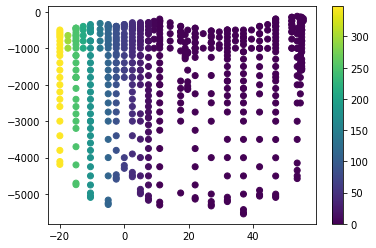

Adding penalty for LCDW


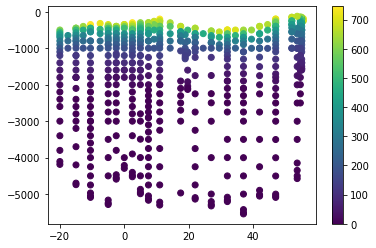

Adding penalty for AABW


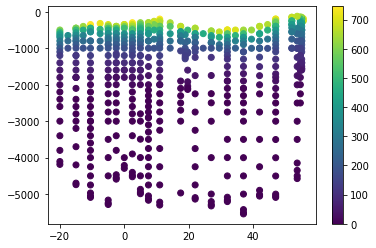

Conversion ratios:
[[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
params to use: ['potential_temp', 'practical_salinity', 'silicate'] ['nitrate', 'phosphate', 'oxygen']
param weighting: [560 800  30  50  50  10]
ratio [[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
status: optimal
optimal value 2493893.3359029507
status: optimal
optimal value 87233019.58492424
status: optimal
optimal value 2219935.3252430665
objective: 2201712.4901560624
intermediateanddeep_withpenalty_flexibleconversion rian_weighting_noconversion
[]
Adding penalty for PSUW


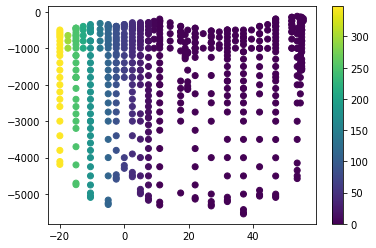

Adding penalty for LCDW


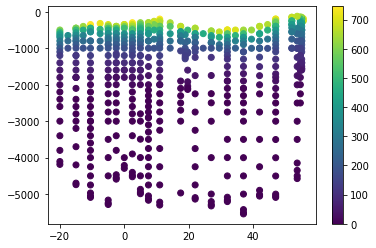

Adding penalty for AABW


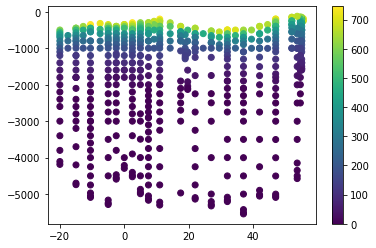

Conversion ratios:
[]
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'PO'] []
param weighting: [560 800  30  10   5]
ratio []
status: optimal
optimal value 5296318.037380288
status: optimal
optimal value 5296318.037380288
status: optimal
optimal value 5296318.037380288
objective: 5231391.000222242
intermediateanddeep_withpenalty_staticconversion rian_weighting_withconversion
[('nitrate', 50), ('phosphate', 50), ('oxygen', 10)]
Adding penalty for PSUW


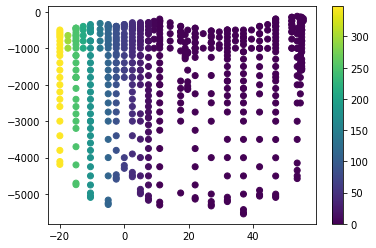

Adding penalty for LCDW


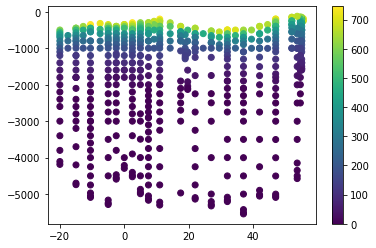

Adding penalty for AABW


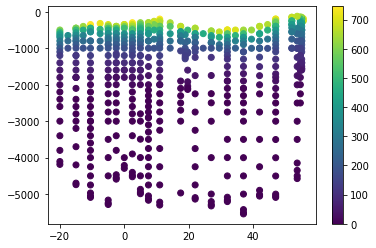

Conversion ratios:
[[ 0.10330579  0.00645161 -1.        ]]
params to use: ['potential_temp', 'practical_salinity', 'silicate'] ['nitrate', 'phosphate', 'oxygen']
param weighting: [560 800  30  50  50  10]
ratio [[ 0.10330579  0.00645161 -1.        ]]
status: optimal
optimal value 2498921.0331912814
status: optimal
optimal value 87233360.93977208
status: optimal
optimal value 2225266.041952559
objective: 2207056.0688208127
intermediateanddeep_withpenalty_staticconversion rian_weighting_noconversion
[]
Adding penalty for PSUW


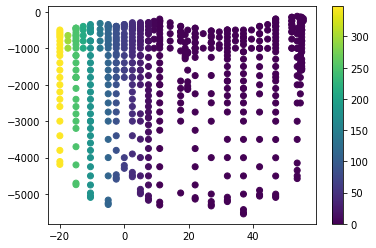

Adding penalty for LCDW


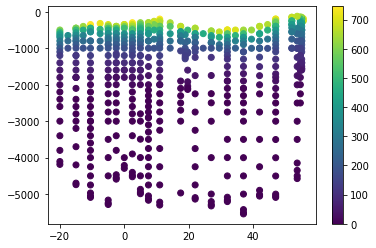

Adding penalty for AABW


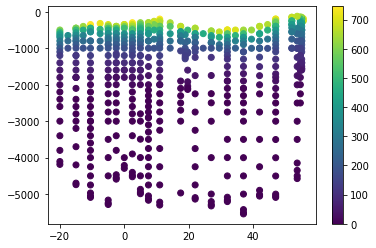

Conversion ratios:
[]
params to use: ['potential_temp', 'practical_salinity', 'silicate', 'NO', 'PO'] []
param weighting: [560 800  30  10   5]
ratio []
status: optimal
optimal value 5296318.037380288
status: optimal
optimal value 5296318.037380288
status: optimal
optimal value 5296318.037380288
objective: 5231391.000222242


In [71]:
import pyompa
reload(pyompa)
from pyompa import OMPAProblem, get_wm_penalty_func
from collections import OrderedDict

gp15_intermediate = gp15_df[(gp15_df["sig0"] >= 26.6)
                            & (gp15_df["sig0"] <= 27.72)]

gp15_intermediateanddeep = pd.DataFrame(gp15_df[(gp15_df["sig0"] >= 26.6)])

intermediate_paramsandweighting_nospicy = ([("potential_temp",140),
                                            ("practical_salinity",100),
                                            ("silicate",30),
                                            ("NO",10),
                                            #("PO",10),
                                            #("spiciness",10),
                                            #("PV",10),
                                           ], [])

#default redfield: C:N:P:O = 106:16:1:-155
#Teng et al says C:P is in the range 66 to 209
#Assuming relative ratios of other things stay the same, then -O/P goes from
# -155*(66/106) to -155*(209/106)
conversionratios_flexible = {
    "oxygen": [-1,-1],
    "nitrate": [1.0/9.68, 1.0/9.68],
    "phosphate": [1.0/(155.0*(66.0/106.0)), 1.0/(155.0*(209.0/106.0))],
}

conversionratios_static = {
    "oxygen": [-1],
    "nitrate": [1.0/9.68],
    "phosphate": [1.0/155.0],
}

rian_weighting_withconversion = (
 [("potential_temp",560), ("practical_salinity",800),("silicate",30)],
 [("nitrate", 50), ("phosphate", 50), ("oxygen", 10)])

rian_weighting_noconversion = (
 [("potential_temp",560), ("practical_salinity",800),
  ("silicate",30), ("NO",10),("PO",5)], [])

watermassdfname_to_dfs = OrderedDict()  

watermass_usagepenalty = {
    PSUW[0]: get_wm_penalty_func(latbounds=(10,np.inf), sig0bounds=None),
    P16_LCDW[0]: get_wm_penalty_func(latbounds=None,
                                     sig0bounds=(27.72,np.inf)),
    GLODAP_AABW[0]: get_wm_penalty_func(latbounds=None,
                                        sig0bounds=(27.72,np.inf))}

watermassdfname_to_dfs['intermediateanddeep_withpenalty_flexibleconversion'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23,
                          P16_LCDW,
                          GLODAP_AABW
                          ]),
   gp15_intermediateanddeep,
   watermass_usagepenalty,
   conversionratios_flexible)
  
watermassdfname_to_dfs['intermediateanddeep_withpenalty_staticconversion'] =\
  (prepare_water_mass_df([P16_Emilie_AAIW,
                          PSUW,
                          GLODAP_ESSW,
                          GLODAP_NPIW,
                          PDW1,
                          P16_UCDW,
                          PDW23,
                          P16_LCDW,
                          GLODAP_AABW
                          ]),
   gp15_intermediateanddeep,
   watermass_usagepenalty,
   conversionratios_static)


ompa_setting_to_soln = OrderedDict()
for watermassdfname, (watermass_df, obs_df, usagepenalty, conversionratios)\
  in watermassdfname_to_dfs.items():
    for (weightingname, (weighting_conserved, weighting_converted)) in [
             ("rian_weighting_withconversion", rian_weighting_withconversion),
             ("rian_weighting_noconversion", rian_weighting_noconversion),
             ]:
        for smoothness_lambda in [None]:#, 10000]:#, 100000, 1000000]:
            print(watermassdfname, weightingname)
            ompa_problem = OMPAProblem(
              watermass_df = watermass_df,
              obs_df = obs_df,
              paramsandweighting_conserved=weighting_conserved,
              paramsandweighting_converted=weighting_converted,
              conversionratios=conversionratios,
              smoothness_lambda=smoothness_lambda,
              watermassname_to_usagepenaltyfunc=usagepenalty)
            ompa_problem.solve()
            ompa_setting_to_soln[(watermassdfname,
                                  smoothness_lambda,
                                  weightingname)] = ompa_problem
            #ompa_problem.construct_ideal_endmembers()


Plotting water mass fractions
Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_withconversion')


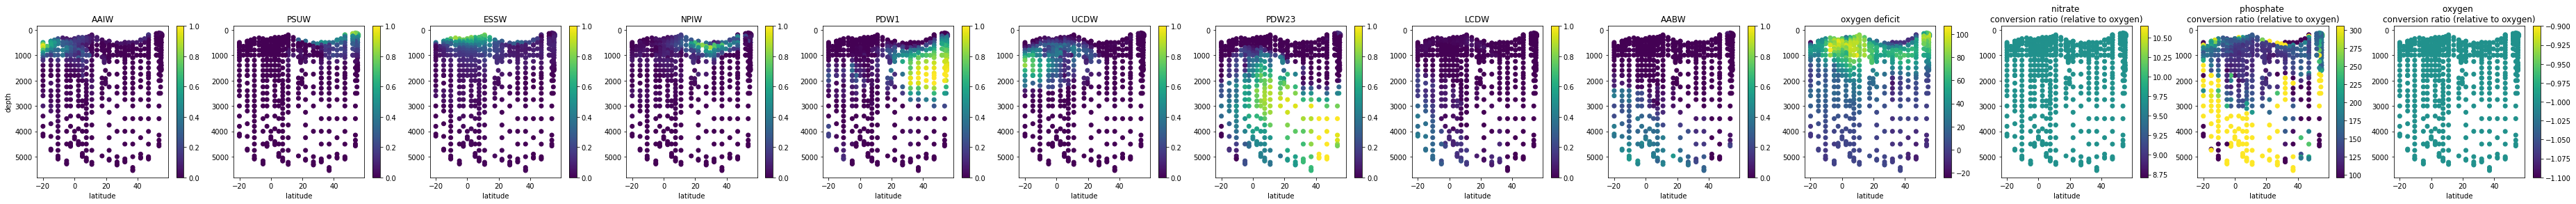

Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_noconversion')


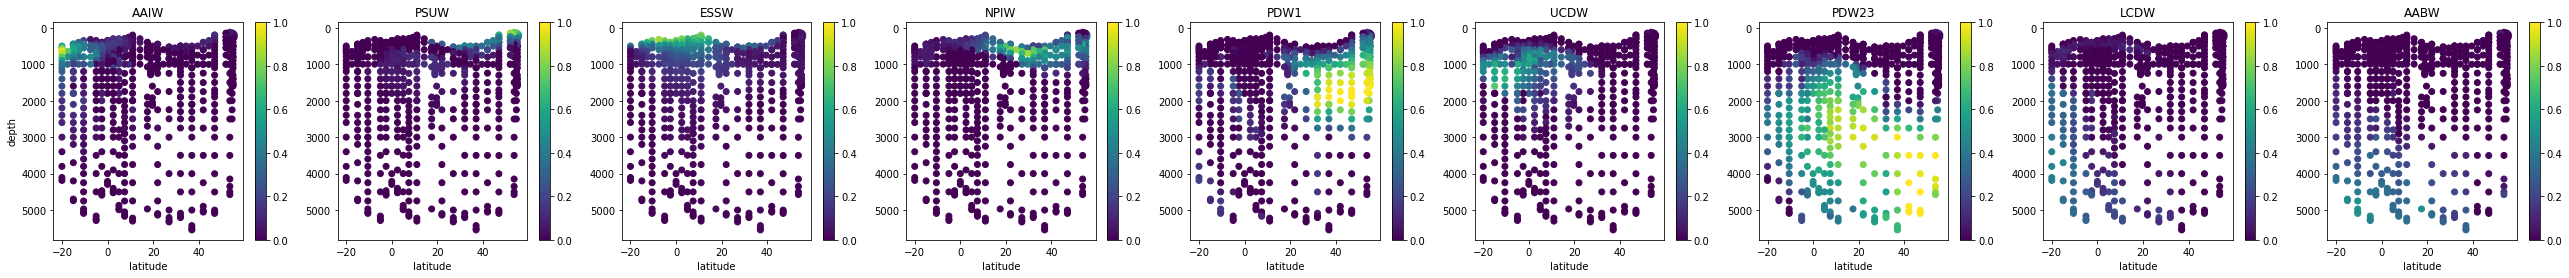

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_withconversion')


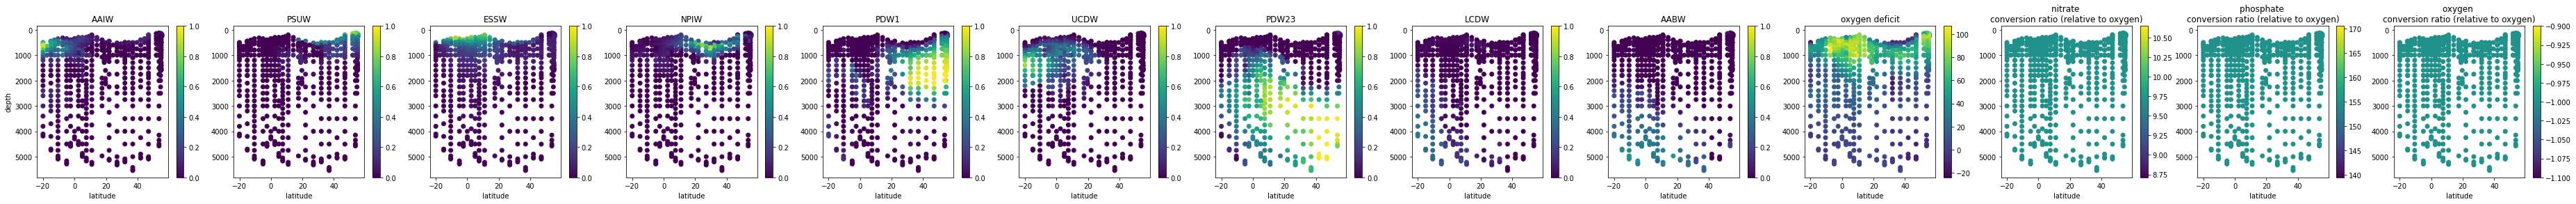

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_noconversion')


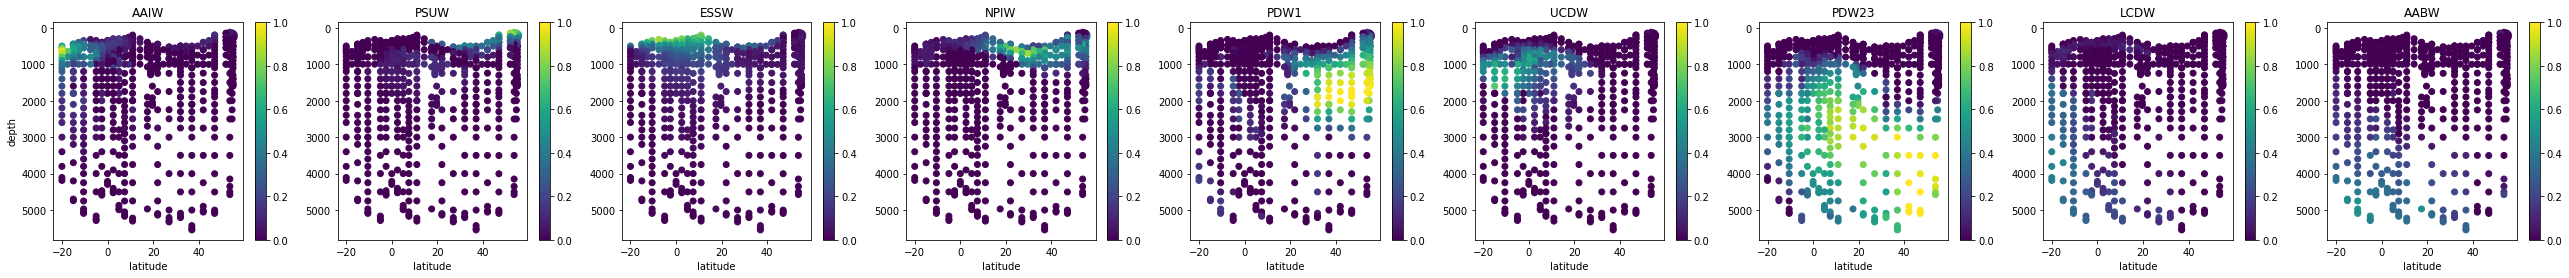

Plotting absolute residuals
Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_withconversion')


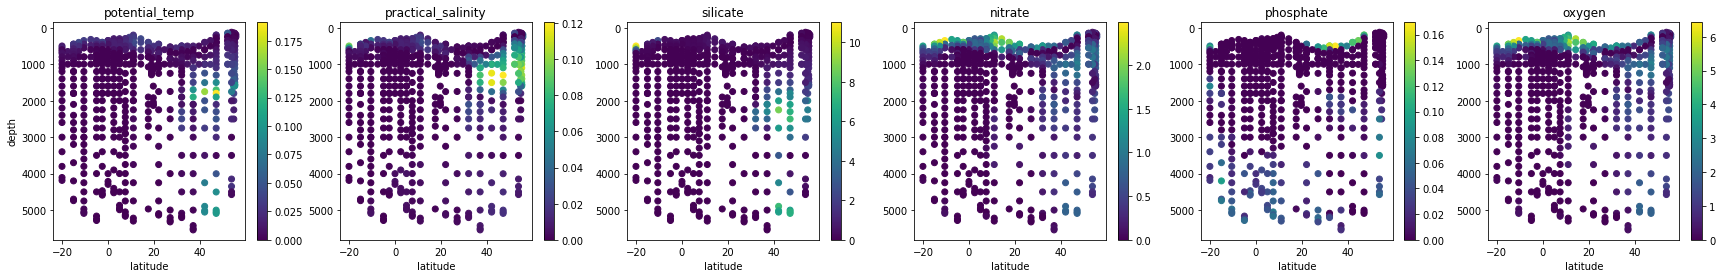

Setting: ('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_noconversion')


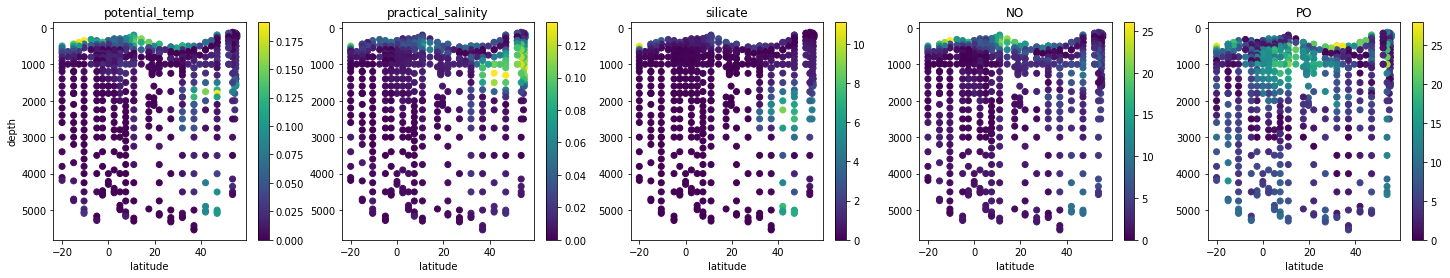

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_withconversion')


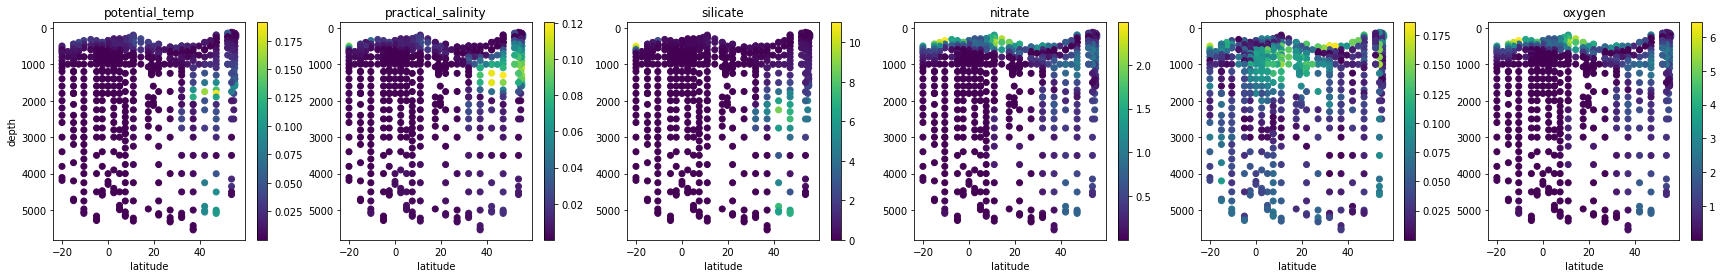

Setting: ('intermediateanddeep_withpenalty_staticconversion', None, 'rian_weighting_noconversion')


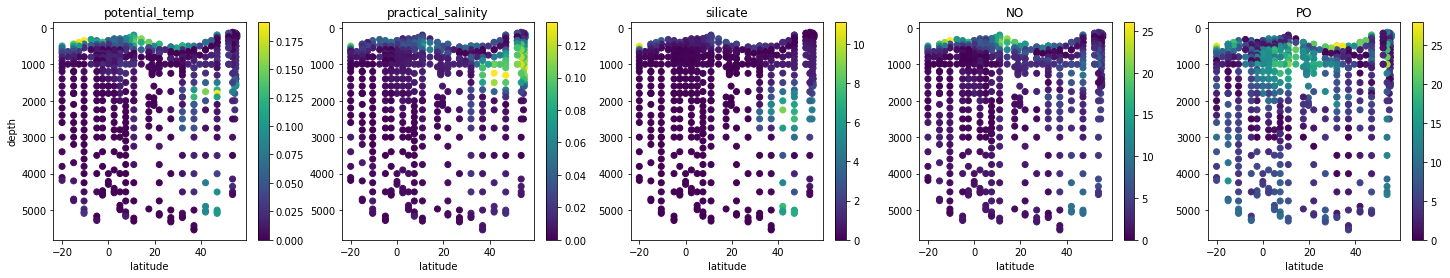

In [19]:
from matplotlib import pyplot as plt
from pyompa import plot_water_mass_fractions, plot_residuals


print("Plotting water mass fractions")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    ompa_problem = ompa_setting_to_soln[setting]
    plot_water_mass_fractions(
        latitudes=ompa_problem.obs_df["latitude"],
        depths=ompa_problem.obs_df["depth"],
        water_mass_fractions=ompa_problem.water_mass_fractions,
        watermassnames=list(ompa_problem.watermass_df["watermassname"]),
        total_oxygen_deficit=ompa_problem.total_oxygen_deficit,
        converted_params_to_use=ompa_problem.converted_params_to_use,
        effective_conversion_ratios=ompa_problem.effective_conversion_ratios)


print("Plotting absolute residuals")
for setting in ompa_setting_to_soln:
    print("Setting:", setting)
    ompa_problem = ompa_setting_to_soln[setting]
    plot_residuals(
        param_residuals=ompa_problem.param_residuals,
        params_to_use=(ompa_problem.conserved_params_to_use
                       + ompa_problem.converted_params_to_use),
        latitudes=ompa_problem.obs_df["latitude"],
        depths=ompa_problem.obs_df["depth"])

status: optimal
optimal value 1131094.1923417184
Old weighted residuals sumsquared: 2201712.490156059
New weighted residuals sumsquared: 1131094.192341718
old residuals


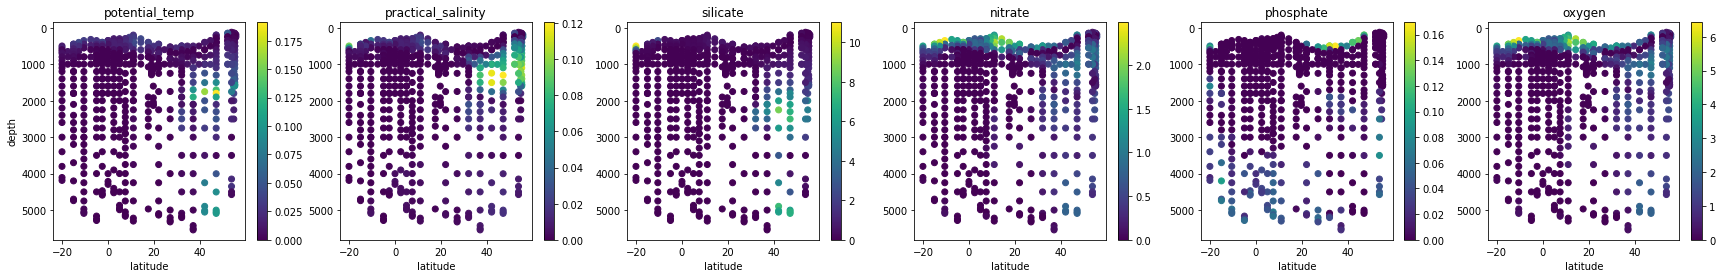

new residuals


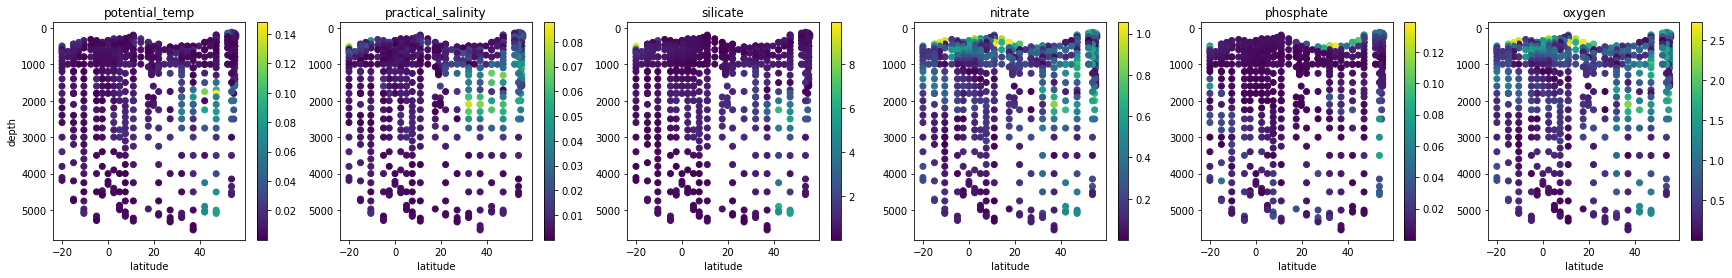

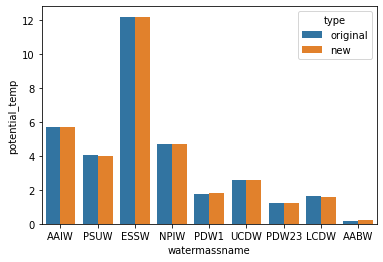

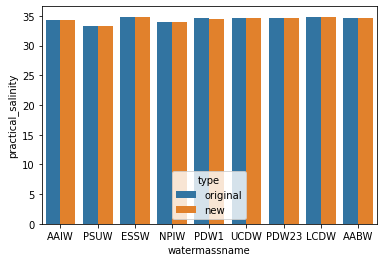

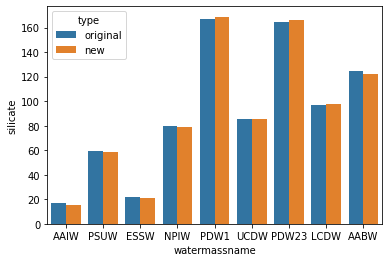

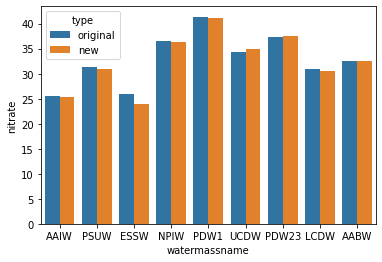

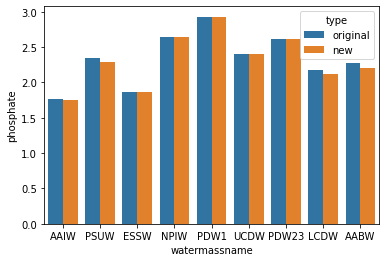

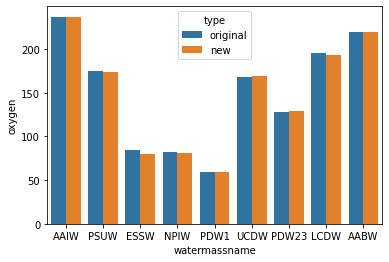

In [74]:
#Compute ideal water masses for the given water mass fractions
ompa_problem=ompa_setting_to_soln[('intermediateanddeep_withpenalty_flexibleconversion', None, 'rian_weighting_withconversion')]
new_wmdf,new_residuals = ompa_problem.construct_ideal_endmembers()
orig_wmdf = ompa_problem.watermass_df
orig_wmdf["type"] = "original"
new_wmdf["type"] = "new"
for_plot_wmdf = pd.concat([orig_wmdf, new_wmdf])

print("old residuals")
plot_residuals(
      param_residuals=ompa_problem.param_residuals,
      params_to_use=(ompa_problem.conserved_params_to_use
                      + ompa_problem.converted_params_to_use),
      latitudes=ompa_problem.obs_df["latitude"],
      depths=ompa_problem.obs_df["depth"])

print("new residuals")
plot_residuals(
      param_residuals=new_residuals,
      params_to_use=(ompa_problem.conserved_params_to_use
                      + ompa_problem.converted_params_to_use),
      latitudes=ompa_problem.obs_df["latitude"],
      depths=ompa_problem.obs_df["depth"])

params_to_use = ompa_problem.conserved_params_to_use+ompa_problem.converted_params_to_use
import seaborn as sns
for param in params_to_use:
  sns.barplot(x="watermassname",
              y=param,
              hue="type",
              data=for_plot_wmdf)
  plt.show()

In [67]:
for_plot_wmdf[for_plot_wmdf["watermassname"]=="PSUW"]

watermassname  potential_temp  practical_salinity  ...     SiO  mass      type
1          PSUW        4.030000           33.380000  ...  1064.8   1.0  original
1          PSUW        4.019239           33.356112  ...     NaN   NaN       new

[2 rows x 14 columns]

In [53]:
b = ompa_problem.get_b()
_, conversion_ratio_rows = ompa_problem.get_conversion_ratio_rows_of_A()
deltas_due_to_oxygen_deficits = ompa_problem.oxygen_deficits@conversion_ratio_rows
b = b - deltas_due_to_oxygen_deficits
existing_endmemmat = np.array(ompa_problem.watermass_df[                        
     ompa_problem.conserved_params_to_use+ompa_problem.converted_params_to_use])
old_param_residuals = b - ompa_problem.water_mass_fractions@existing_endmemmat
np.testing.assert_almost_equal(old_param_residuals, ompa_problem.param_residuals)

array([[ 1.11865703e-02, -3.55451558e-02,  3.46128611e-01,
        -4.57014041e-01, -1.47437618e-13, -1.18030486e+00],
       [ 1.02907375e-02, -3.66515763e-02,  3.44399033e-01,
        -5.46521625e-01, -1.93178806e-13, -1.41147114e+00],
       [ 1.65660667e-03, -5.62349142e-04,  1.74551686e-02,
         8.49867795e-02,  4.88498131e-15,  2.19490650e-01],
       ...,
       [ 3.61640466e-06,  1.04221979e-04, -1.31036404e-04,
         3.20998748e-03, -2.87295810e-02,  8.48087857e-04],
       [ 2.12835580e-06,  6.13375645e-05, -7.71186073e-05,
         1.88916787e-03, -1.69081660e-02,  4.99123544e-04],
       [-1.09226231e-03, -2.52595145e-04, -5.11509171e-03,
        -3.43987994e-02, -2.63284533e-02, -9.56600507e-02]])

In [20]:
from pyompa import build_altair_viz

#Build an interactive visualization
build_altair_viz(ompa_setting_to_soln[
  ('intermediateanddeep_withpenalty_flexibleconversion',
   None, 'rian_weighting_withconversion')])

alt.VConcatChart(...)

Thermocline Analysis

In [21]:
#Thermocline files include endmembers in the range of potential density 22 to 28 
#the Thomson and Krassovski (2010) definition of PSUW (better performing in previous version of the model) could not have its thermocline potnetial density range expanded
#likely due to lack of observation in the lower potential density range 
#the Tomczak and Godfrey (2003) definition of PSUW was used to obtain the 22-28 range 
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u' -O ENPCW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Poki02WafLnFpuc196IFOCgdQVQt_yIs' -O PSUW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=11cJgzVjT98Mkf_vB0gRSzCOTrEbxmz5i' -O ESSW_Den22to28_Oct2020_siderealPV_NO.csv
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1S9QDgIisrGRtST9EXvAMG6lO4Q1XBG3E' -O SPCW_Den22to28_Oct2020_siderealPV_NO.csv

--2021-01-11 18:36:49--  https://docs.google.com/uc?export=download&id=1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u
Resolving docs.google.com (docs.google.com)... 173.194.79.100, 173.194.79.139, 173.194.79.138, ...
Connecting to docs.google.com (docs.google.com)|173.194.79.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mhe103irn69lshhf2t3oq99ign7sjj21/1610390175000/06203730782251856755/*/1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u?e=download [following]
--2021-01-11 18:36:49--  https://doc-0o-a4-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/mhe103irn69lshhf2t3oq99ign7sjj21/1610390175000/06203730782251856755/*/1RhhvaxDue0P6lVpNlXwdzBzQETwnsc1u?e=download
Resolving doc-0o-a4-docs.googleusercontent.com (doc-0o-a4-docs.googleusercontent.com)... 173.194.69.132, 2a00:1450:4013:c04::84
Connecting to doc-0o-a4-docs.googleusercontent.com (doc-0o-a4-d

In [22]:
import pandas as pd

endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
endmemname_to_df ={}

for endmemname in endmemname_to_csv:
  # df=endmemname
  # print(df)
  csv = endmemname_to_csv[endmemname]
  print(csv)
  df = pd.read_csv(csv,names=header, na_values = -999)
  augment_df_with_PO_NO_SiO(df)
  df["watermassname"] = endmemname
  print(df.columns)
  endmemname_to_df[endmemname] = df; 

print(endmemname_to_df["ESSW"])     

PSUW_Den22to28_Oct2020_siderealPV_NO.csv
Index(['stnnbr', 'c2', 'c3', 'c4', 'bottle flag', 'geotrc_ID', 'c7', 'c8',
       'latitude', 'longitude', 'bottom depth', 'CTD pressure',
       'CTD temperature', 'c14', 'c15', 'practical_salinity',
       'bottle salinity flag', 'c18', 'c19', 'oxygen', 'bottle oxygen flag',
       'silicate', 'silicate flag', 'nitrate', 'nitrate flag', 'c26', 'c27',
       'phosphate', 'phosphate flag', 'PO', 'NO', 'SiO', 'watermassname'],
      dtype='object')
ENPCW_Den22to28_Oct2020_siderealPV_NO.csv
Index(['stnnbr', 'c2', 'c3', 'c4', 'bottle flag', 'geotrc_ID', 'c7', 'c8',
       'latitude', 'longitude', 'bottom depth', 'CTD pressure',
       'CTD temperature', 'c14', 'c15', 'practical_salinity',
       'bottle salinity flag', 'c18', 'c19', 'oxygen', 'bottle oxygen flag',
       'silicate', 'silicate flag', 'nitrate', 'nitrate flag', 'c26', 'c27',
       'phosphate', 'phosphate flag', 'PO', 'NO', 'SiO', 'watermassname'],
      dtype='object')
ESSW_Den22to2

In [23]:

def read_in_thermocline_endmemberdfs(endmemname_to_csv):
    #This function reads in the data frames for the thermocline end members
    #It takes endmemname_to_csv as input, which maps the thermocline
    # end member name (e.g. ENPCW) to the corresponding csv file.
    endmemname_to_df = {}
    #iterate through every endmemname in endmemname_to_csv
    #Order of thermocline endmember file columns: Sig0 pt SP O Si N P PO Pres spic0 vor NO Lat Lon T]);
    #e.g.
    header = ["c"+str(i) for i in range(1,17)] 
    header[0] = "sig0" #potential density 
    header[1] = "potential_temp"
    header[2] = "practical_salinity"
    header[3] = "oxygen"
    header[4] = "silicate"
    header[5] = "nitrate"
    header[6] = "phosphate"
    header[7] = "PO" #remove if calculating this later?
    header[8] = "CTD pressure"
    header[9] = "spiciness" #spiciness
    header[10] = "PV" #potential vorticity
    header[11] = "NO" #remove if calculating this later?
    header[12] = "latitude"
    header[13] = "longitude"
    header[14] = "CTD temperature"
    #make sure header names are compatible
    # with those used in the prepare_water_mass_df function defined earlier
    # for intermediate waters.
    for endmemname in endmemname_to_csv.keys():
      #get the csv file corresponding to the endmemname
      csv = endmemname_to_csv[endmemname]
      #read the csv file into a data frame df
      df = pd.read_csv(csv,names=header, na_values = -999)
      augment_df_with_PO_NO_SiO(df)
      #Also add a column to the df that just has the end member name
      # repeated for each row. This will come in handy later when
      # pairing rows from different data frames
      df["watermassname"] = endmemname
      #store df in endmemname_to_df with the key endmemname
      endmemname_to_df[endmemname] = df; 

    return endmemname_to_df


#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)


In [24]:
print("First ten rows")
!head "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"
print("last ten rows")
!tail "PSUW_Den22to28_Oct2020_siderealPV_NO.csv"

First ten rows
22,64.431,42.697,6.2569,85.31,54.442,4.7607,804.22,-68.018,18.211,9.9471e-08,716.82,-72.15,-80.999,64.427
22.01,63.657,42.508,10.37,84.011,53.425,4.6727,793.96,-66.984,17.912,9.7867e-08,708.26,-69.988,-82.148,63.652
22.02,62.89,42.322,14.441,82.725,52.42,4.5856,783.83,-65.959,17.616,9.628e-08,699.8,-67.85,-83.283,62.886
22.03,62.132,42.138,18.47,81.453,51.426,4.4996,773.81,-64.944,17.323,9.4709e-08,691.44,-65.734,-84.407,62.127
22.04,61.381,41.956,22.456,80.195,50.444,4.4145,763.91,-63.939,17.034,9.3154e-08,683.17,-63.642,-85.517,61.377
22.05,60.638,41.776,26.401,78.951,49.472,4.3305,754.13,-62.943,16.747,9.1616e-08,675,-61.573,-86.615,60.634
22.06,59.903,41.598,30.303,77.72,48.513,4.2474,744.47,-61.957,16.464,9.0094e-08,666.93,-59.526,-87.701,59.899
22.07,59.175,41.422,34.164,76.503,47.564,4.1654,734.93,-60.981,16.183,8.8589e-08,658.95,-57.502,-88.775,59.171
22.08,58.455,41.248,37.984,75.3,46.626,4.0843,725.5,-60.014,15.906,8.7099e-08,651.07,-55.501,-89.836,58.451
22.09

In [25]:
from pyompa import ThermoclineArrayOMPAProblem

#To read in thermocline files via a for loop, first create a dictionary that maps the
# end member name (e.g. PSUW) to the paths for the csv files that
# should be used
endmemname_to_csv = {
    "PSUW": "PSUW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ENPCW": "ENPCW_Den22to28_Oct2020_siderealPV_NO.csv",
    "ESSW": "ESSW_Den22to28_Oct2020_siderealPV_NO.csv",
    "SPCW": "SPCW_Den22to28_Oct2020_siderealPV_NO.csv"
}
#Then, call a function that will run a for loop to read in
# the data frames for the thermocline endmembers.
#The function will return a dictionary that maps the
# thermocline end member to the corresponding dataframe
endmemname_to_df = read_in_thermocline_endmemberdfs(endmemname_to_csv)

#Define thermocline
#By convention, constants are in all caps
TC_UPPER_BOUND = 26.6
TC_LOWER_BOUND = 25.5
TC_STEP = 0.01
therm_endmem_to_use = ["PSUW","ENPCW","ESSW", "SPCW"] #thermocline water masses for analysis
# members to use in the analysis 
gp15_thermocline = gp15_df[(gp15_df["sig0"] >= TC_LOWER_BOUND)
                            & (gp15_df["sig0"] <= TC_UPPER_BOUND)]

rescale = 0.1 #for stabilizing the solver
withspicnoNO_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*155),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   ("spiciness",rescale*10),
                                   #("PV",10),
                                   ],
    [])

withRemin_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*155),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50),
     ("phosphate", rescale*50),
     ("oxygen", rescale*10)])

higherSal_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*600),
                                   ("silicate",rescale*5),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50),
     ("phosphate", rescale*50),
     ("oxygen", rescale*10)])

higherSal2_thermocline_paramsandweighting = ([("potential_temp",rescale*200),
                                   ("practical_salinity",rescale*600),
                                   ("silicate",rescale*8),
                                   #("NO",10),
                                   #("PO",10),
                                   #("spiciness",10),
                                   #("PV",10),
                                   ],
    [("nitrate", rescale*50),
     ("phosphate", rescale*150),
     ("oxygen", rescale*10)])

settings_to_thermoclineomparesults = OrderedDict()

for (t_paramsandweightingname, thermocline_paramsandweighting) in [
          ('withSpic_noNO', withspicnoNO_thermocline_paramsandweighting),
          ('withRemin_noSpic', withRemin_thermocline_paramsandweighting),
          ('withRemin_noSpic_higherSal', higherSal_thermocline_paramsandweighting),
          ('withRemin_noSpic_higherSal_higherSil_higherP', higherSal2_thermocline_paramsandweighting),
          ]:
  for conversionratios, conversionratiosname in [
            (conversionratios_static, 'staticratios'),
            (conversionratios_flexible, 'flexibleratios')]:
      print("params and weight name:", t_paramsandweightingname)
      print("conversionrationame", conversionratiosname)

      settings_to_thermoclineomparesults[
        (t_paramsandweightingname,
         conversionratiosname)] = ThermoclineArrayOMPAProblem(
             tc_lower_bound=TC_LOWER_BOUND,
             tc_upper_bound=TC_UPPER_BOUND,
             tc_step=TC_STEP,
             endmemnames_to_use=therm_endmem_to_use,
             endmemname_to_df=endmemname_to_df,
             obs_df=gp15_thermocline,
             paramsandweighting_conserved=thermocline_paramsandweighting[0],
             paramsandweighting_converted=thermocline_paramsandweighting[1],
             conversionratios=conversionratios,
             watermassname_to_usagepenaltyfunc={}
         ).solve()

Streaming output truncated to the last 5000 lines.
optimal value 0.7322887529006018
status: optimal
optimal value 4.932695556018962
status: optimal
optimal value 0.7322887529006018
objective: 0.7322887529007491
[('nitrate', 5.0), ('phosphate', 5.0), ('oxygen', 1.0)]
Conversion ratios:
[[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
params to use: ['potential_temp', 'practical_salinity', 'silicate'] ['nitrate', 'phosphate', 'oxygen']
param weighting: [20.  15.5  0.5  5.   5.   1. ]
ratio [[ 0.10330579  0.01036168 -1.        ]
 [ 0.10330579  0.00327211 -1.        ]]
status: optimal
optimal value 106.41339435233434
status: optimal
optimal value 115.21362044847776
status: optimal
optimal value 106.41339435233434
objective: 106.41339435234474
No observations for range 25.720000000000034 25.730000000000036
No observations for range 25.730000000000036 25.740000000000038
[('nitrate', 5.0), ('phosphate', 5.0), ('oxygen', 1.0)]
Conversion ratios:
[[ 0.10330579  0.0

Visualization of Thermocline 

Plotting water mass fractions
('withSpic_noNO', 'staticratios')


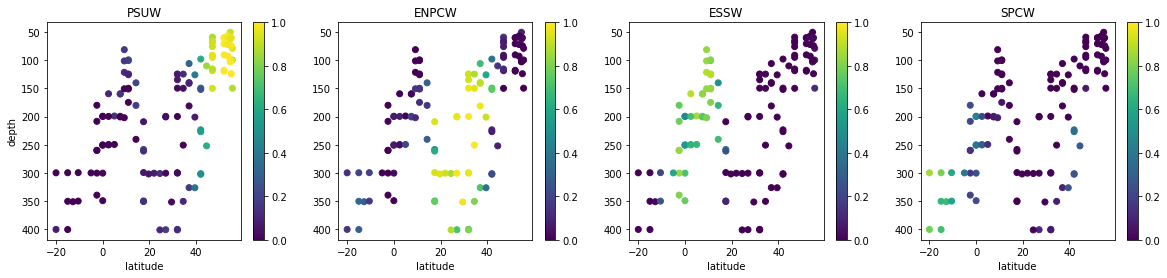

('withSpic_noNO', 'flexibleratios')


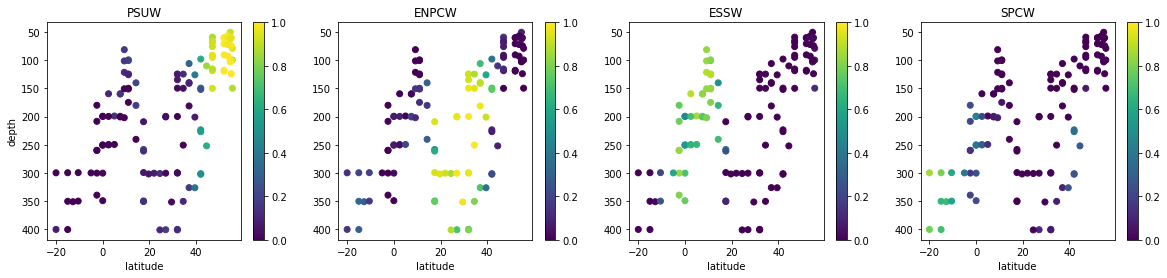

('withRemin_noSpic', 'staticratios')


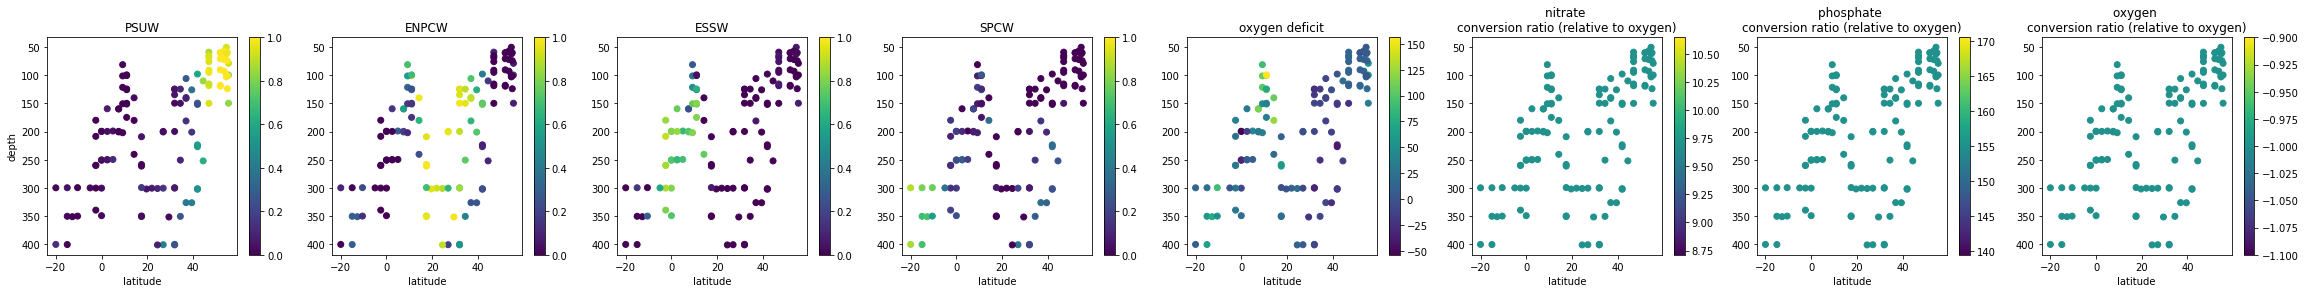

('withRemin_noSpic', 'flexibleratios')


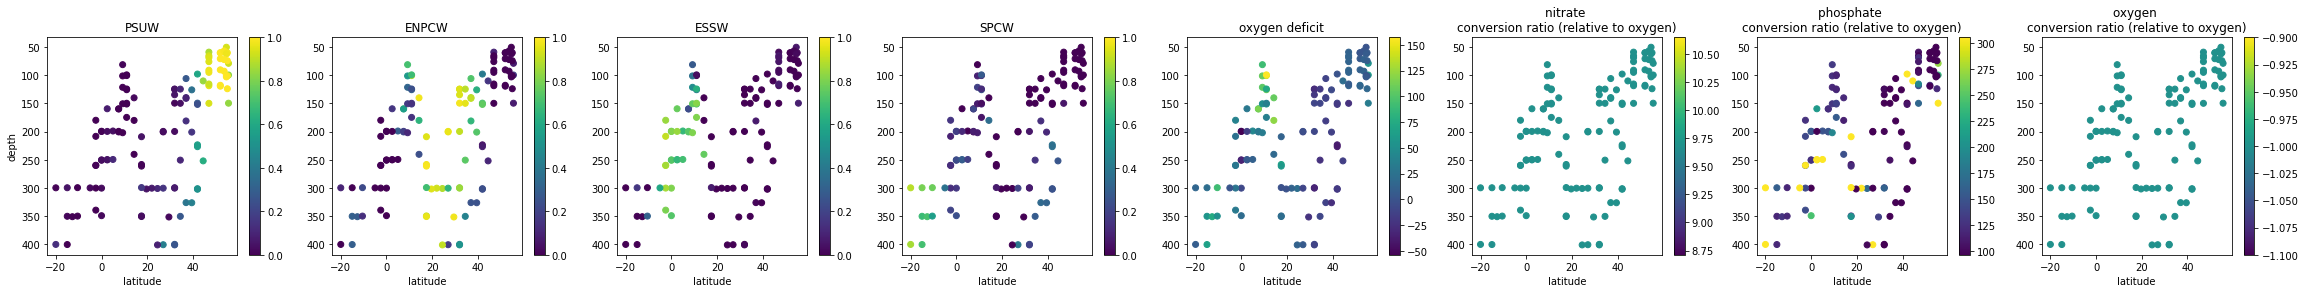

('withRemin_noSpic_higherSal', 'staticratios')


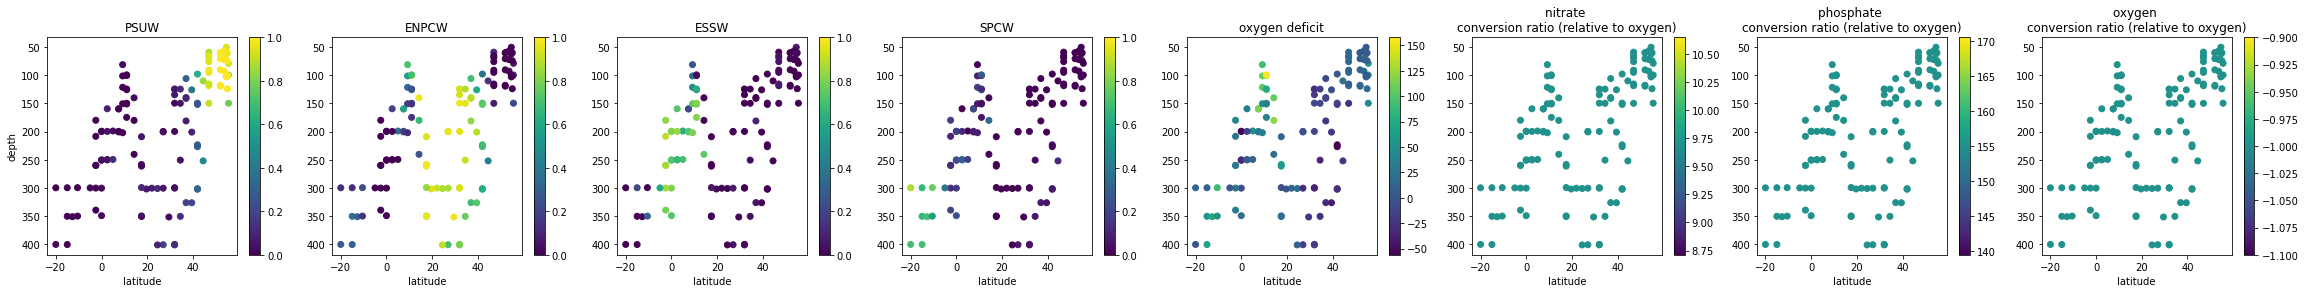

('withRemin_noSpic_higherSal', 'flexibleratios')


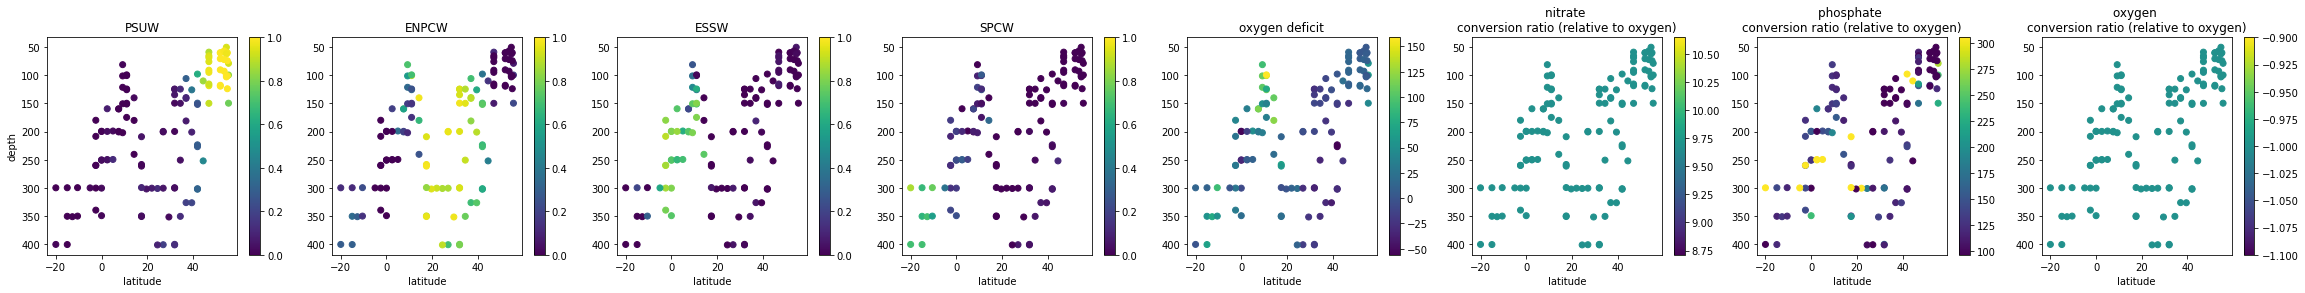

('withRemin_noSpic_higherSal_higherSil_higherP', 'staticratios')


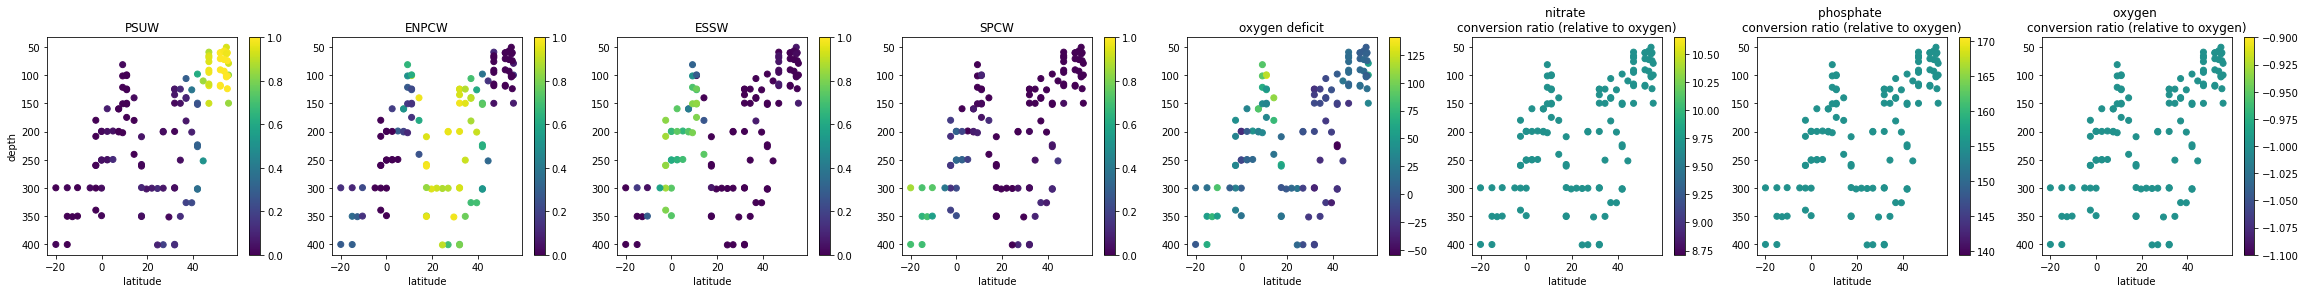

('withRemin_noSpic_higherSal_higherSil_higherP', 'flexibleratios')


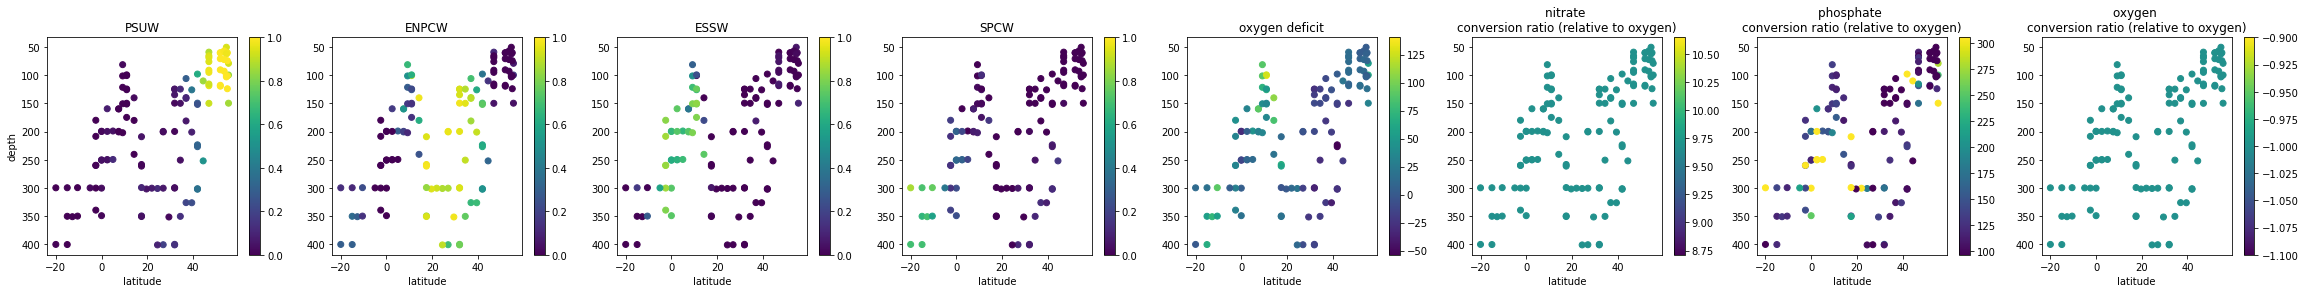

In [26]:
from pyompa import plot_thermocline_water_mass_fractions

print("Plotting water mass fractions")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
  print(setting)
  plot_thermocline_water_mass_fractions(thermocline_ompa_results)

Plotting parameter residuals
('withSpic_noNO', 'staticratios')


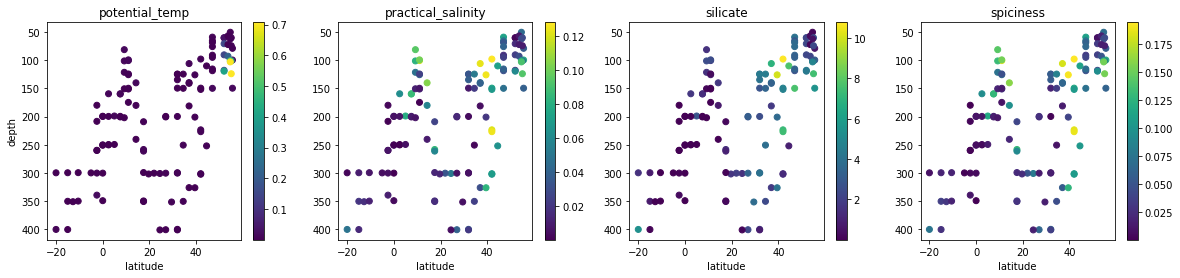

('withSpic_noNO', 'flexibleratios')


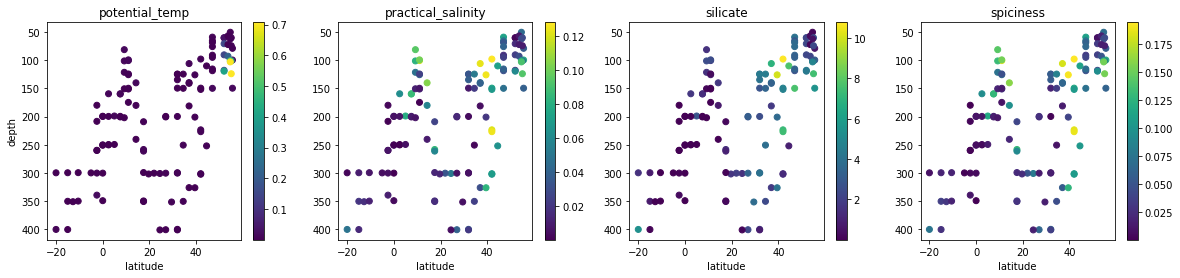

('withRemin_noSpic', 'staticratios')


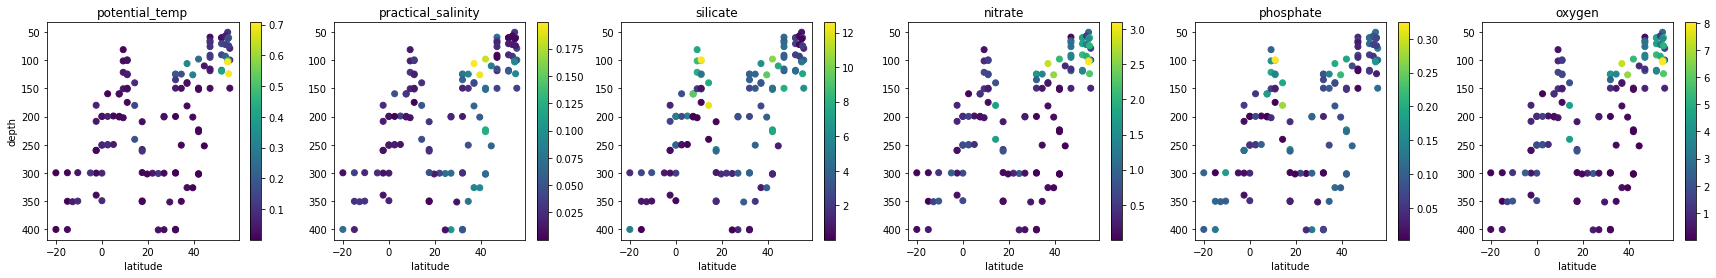

('withRemin_noSpic', 'flexibleratios')


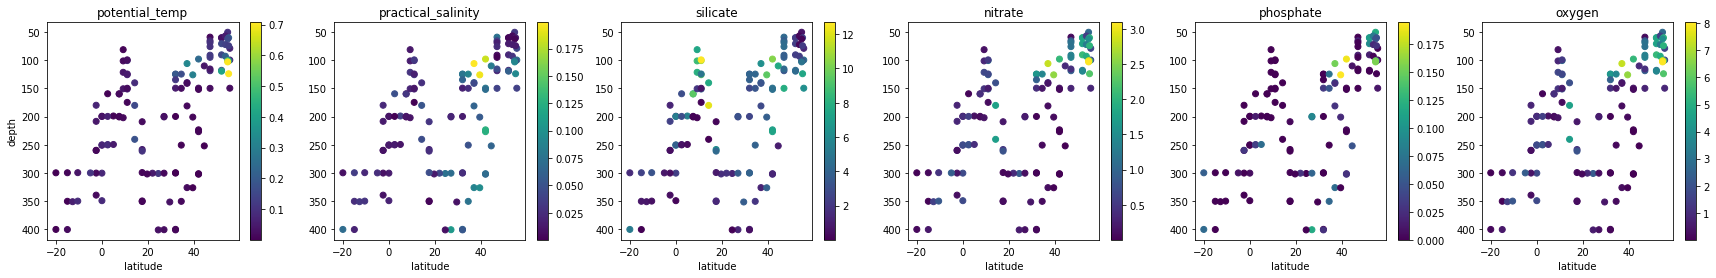

('withRemin_noSpic_higherSal', 'staticratios')


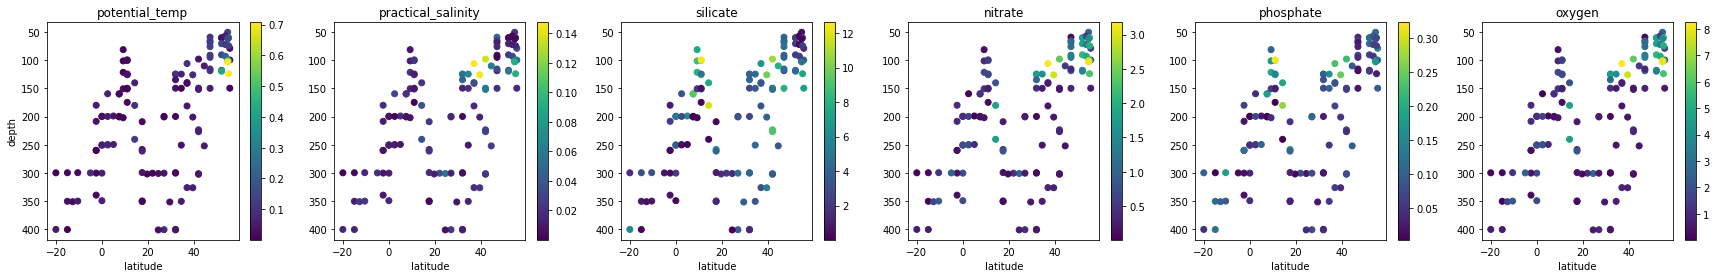

('withRemin_noSpic_higherSal', 'flexibleratios')


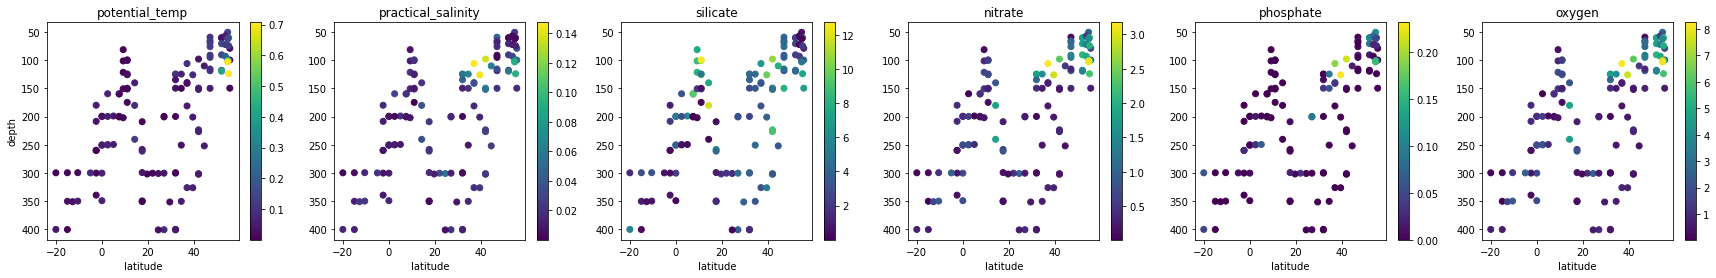

('withRemin_noSpic_higherSal_higherSil_higherP', 'staticratios')


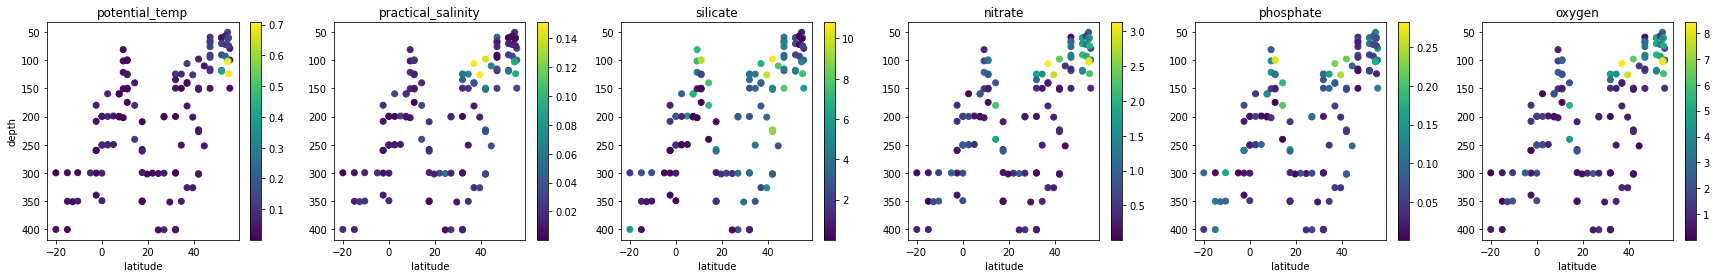

('withRemin_noSpic_higherSal_higherSil_higherP', 'flexibleratios')


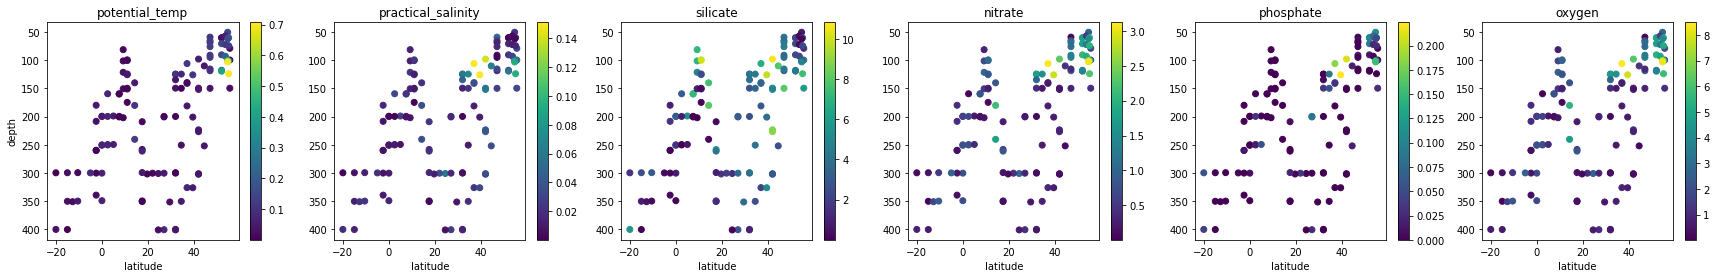

In [27]:
from pyompa import plot_thermocline_residuals


print("Plotting parameter residuals")
for setting,thermocline_ompa_results in\
  settings_to_thermoclineomparesults.items():
  print(setting)
  plot_thermocline_residuals(thermocline_ompa_results[:])


In [28]:
from pyompa import build_thermocline_altair_viz

build_thermocline_altair_viz(
    settings_to_thermoclineomparesults[(
        'withRemin_noSpic_higherSal_higherSil_higherP', 'flexibleratios')])

alt.VConcatChart(...)